-----------

-----------

## 1. Postgresql 연동 라이브러리 로딩 및 DB 접속

In [9]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.rcParams['font.family']='AppleGothic'
plt.rcParams['axes.unicode_minus']=False

In [3]:
conn_string = 'postgresql://'
postgres_engine = create_engine(conn_string)

-----
## 2. 데이터 Import 및 확인
- orders 테이블: 주문 데이터
- order_items 테이블: 주문 상세 데이터
- customers 테이블: 고객 데이터
- products 테이블: 상품 정보
- sellers 테이블: 판매자 정보
- product_category 테이블: 브라질어로 되어 있는 카테고리명을 영어로 번역한 테이블  


### ***데이터 구조
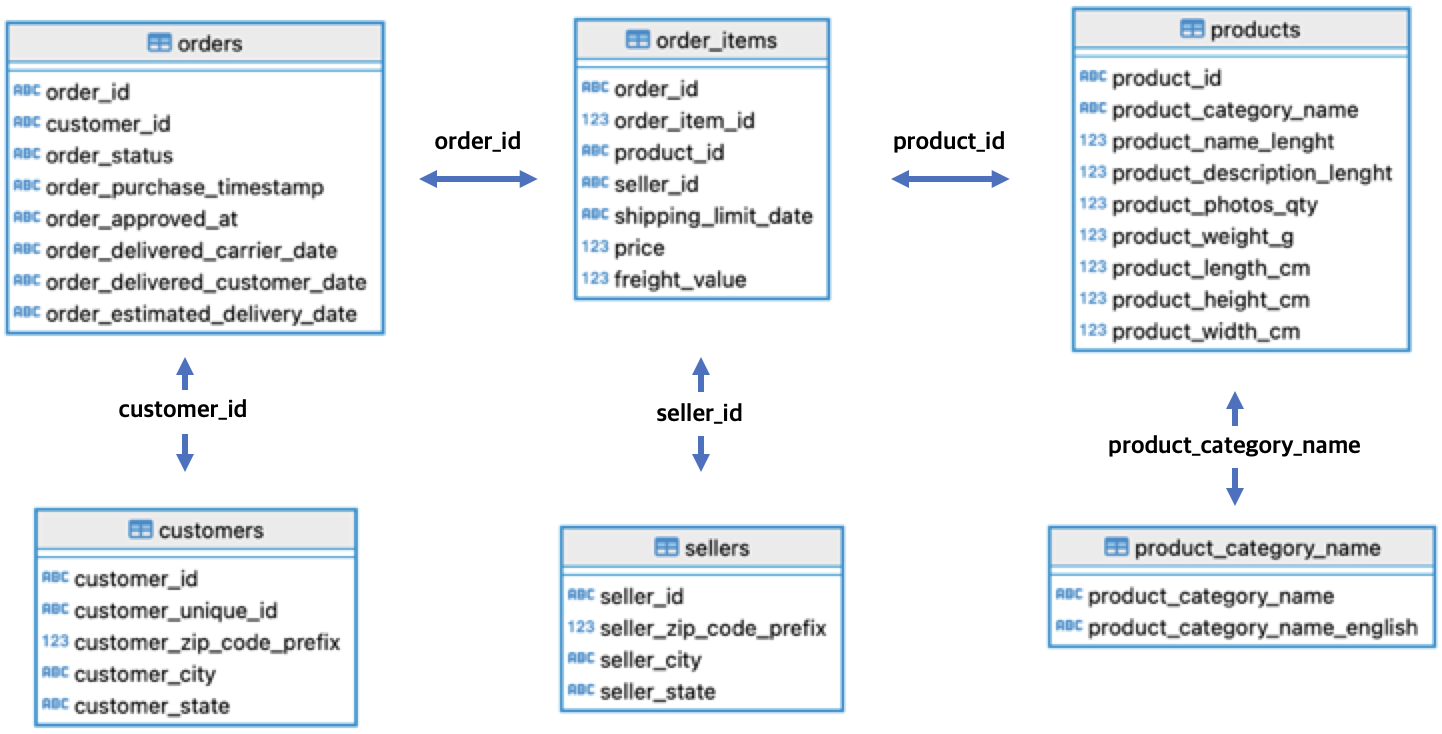


### 2-1. order 테이블
- 전체 99,441건의 주문 데이터 중 주문 승인(order_approved_at), 배송 관련 날짜(order_delivered_carrier_date, order_delivered_customer_date) 데이터에 Null 값이 존재한다.
- order_status에 따라 주문 진행 과정의 날짜가 Null 값으로 존재할 수 있다.

In [21]:
query = """
select *
from olist.orders
"""
df_orders = pd.read_sql_query(sql=query, con=postgres_engine)
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


### 2-2. order_items 테이블
- 결측값은 없으며 총 112,650건의 주문 상세 데이터가 있다.
- order_id 컬럼에 중복값이 존재하며 order_item_id는 1부터 21까지 있는 것으로 확인되는데, 이는 해당 주문 건(order_id)의 주문 상품 수량(order_item_id)으로 추정된다.

In [4]:
query = """
select *
from olist.order_items
"""
df_order_items = pd.read_sql_query(sql=query, con=postgres_engine)
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


### 2-3. customers 테이블
- 전체 99,441건의 고객 데이터 중 customer_unique_id에 중복 데이터가 있으며 고유값이 총 96,096건이 있고 결측값은 없다.
- customer_unique_id가 고객의 고유한 ID이며 customer_id를 통해 해당 고객의 재구매 횟수를 확인할 수 있다.

In [5]:
query = """
select *
from olist.customers
"""
df_customers = pd.read_sql_query(sql=query, con=postgres_engine)
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [6]:
print('Number of customer_ids: ', df_customers.customer_id.nunique())
print('Number of customer_unique_ids: ', df_customers.customer_unique_id.nunique())

Number of customer_ids:  99441
Number of customer_unique_ids:  96096


### 2-4. products 테이블
- 32,951건의 상품 정보가 있으며 74개의 카테고리로 분류되어 있다.
- 상품 카테고리 정보 등이 브라질어로 되어 있어 product_category_name 테이블과 join하여 영문 카테고리명을 확인할 수 있다.
- 상품명 길이(product_name_lenght)와 상품 상세설명 길이(product_description_lenght), 사진 수(product_photos_qty) 등에 결측값이 있다.

In [7]:
query = """
select *
from olist.products
"""
df_products = pd.read_sql_query(sql=query, con=postgres_engine)
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [165]:
df_products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


### 2-5. sellers 테이블
- 3,095명의 판매자가 olist 플랫폼에 판매자로 등록되어 있다.
- 지역 정보가 포함되어 있으며 결측값은 없다.

In [8]:
query = """
select *
from olist.sellers
"""
df_sellers = pd.read_sql_query(sql=query, con=postgres_engine)
df_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


--------
## 3. Preprocessing

### 3-1. 결측치 처리 및 자료형 변환
- orders 테이블의 배송완료 날짜 ('order_delivered_customer_date') 데이터에 2,965건(전체의 약 3%)의 Null값이 있다.
- 해당 결측값을 배송예정 날짜('order_estimated_delivery_date')로 채운다.
- timestamp 값을 date로 바꿔 일별 매출, 배송 기간 계산 등에 사용한다.

In [45]:
query = """
select order_id, customer_id, order_status, order_purchase_timestamp::date
    , (case when order_delivered_customer_date is null then order_estimated_delivery_date else order_delivered_customer_date end)::date as order_delivered_customer_date
    , order_estimated_delivery_date::date
from olist.orders
"""
df_orders = pd.read_sql_query(sql=query, con=postgres_engine)
df_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-10,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-08-07,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-17,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-12-02,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-16,2018-02-26
...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09,2017-03-17,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06,2018-02-28,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27,2017-09-21,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08,2018-01-25,2018-02-15


In [27]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_delivered_customer_date  99441 non-null  object
 5   order_estimated_delivery_date  99441 non-null  object
dtypes: object(6)
memory usage: 4.6+ MB


### 3.2 데이터 축소
- 주문데이터 중 1,239건(전체의 약 1.2%)의 주문은 주문상태('order_status')가 unavailable, canceled, created로 주문상세데이터(order_items 테이블)가 없으므로 해당 분석에서 제외한다.

<!-- - 주문데이터 중 775건(전체의 약 0.78%)의 주문에 대한 주문상세데이터(order_items 테이블)가 없다. 해당 건은 주문상태('order_status')가 unavailable, canceled, created인 주문데이터로 해당 분석에서는 제외한다. -->

In [62]:
query = """
select order_id, customer_id, order_status, order_purchase_timestamp::date
    , (case when order_delivered_customer_date is null then order_estimated_delivery_date else order_delivered_customer_date end)::date as order_delivered_customer_date
    , order_estimated_delivery_date::date
from olist.orders
where order_status not in ('unavailable', 'canceled', 'created')
"""
df_orders = pd.read_sql_query(sql=query, con=postgres_engine)
df_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-10,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-08-07,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-17,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-12-02,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-16,2018-02-26
...,...,...,...,...,...,...
98197,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09,2017-03-17,2017-03-28
98198,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06,2018-02-28,2018-03-02
98199,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27,2017-09-21,2017-09-27
98200,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08,2018-01-25,2018-02-15


In [141]:
df.order_status.value_counts()

delivered     96211
shipped        1097
processing      299
invoiced        296
approved          2
Name: order_status, dtype: int64

- 일별 주문 건수를 시각화해보면 2016년 데이터와 2018년 이후 데이터가 촘촘하지 않거나 거의 없다. 따라서 해당 분석에서는 2017년 1월 1일부터 2018년 8월 31일까지의 데이터만 사용한다.

In [65]:
df_orders.order_purchase_timestamp.value_counts().sort_index()

2016-09-04     1
2016-09-15     1
2016-10-03     7
2016-10-04    58
2016-10-05    42
              ..
2018-08-26    73
2018-08-27    66
2018-08-28    39
2018-08-29    11
2018-09-03     1
Name: order_purchase_timestamp, Length: 614, dtype: int64

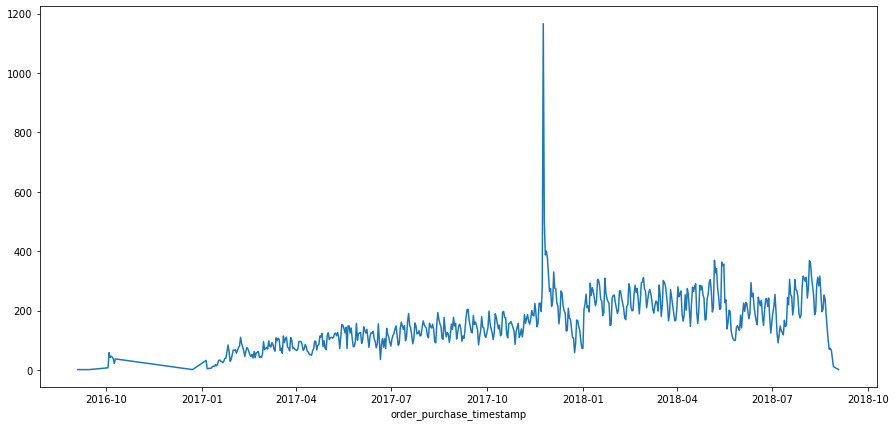

In [59]:
order_cnt = df_orders.groupby('order_purchase_timestamp')['order_id'].count()
sns.lineplot(x = order_cnt.index, y = order_cnt.values, data = order_cnt)
plt.gcf().set_size_inches(15, 7)
plt.show()

### 3-3. 테이블 통합
- 축소한 주문데이터를 기준으로 상품테이블과 고객테이블, 판매자테이블을 통합하여 하나의 테이블을 만든다.

In [4]:
query = """
with temp_01 as (
select order_id, customer_id, order_status, order_purchase_timestamp::date
    , (case when order_delivered_customer_date is null then order_estimated_delivery_date else order_delivered_customer_date end)::date as order_delivered_customer_date
    , order_estimated_delivery_date::date
from olist.orders
where order_status not in ('unavailable', 'canceled', 'created')
    and order_purchase_timestamp::date between '2017-01-01' and '2018-08-31'
),
temp_02 as (
select order_id, max(product_id) as product_id, max(seller_id) as seller_id
	, max(order_item_id)::int as order_qty
	, round(avg(price))::int as avg_unit_price
from olist.order_items
group by 1
)
select a.order_id, a.customer_id, e.customer_unique_id, e.customer_state, order_status
	, order_purchase_timestamp, order_delivered_customer_date, order_estimated_delivery_date
	, order_qty, avg_unit_price, b.product_id, d.product_category_name_english as product_category_name, f.seller_id, f.seller_state
from temp_01 a
	left join temp_02 b on a.order_id = b.order_id
	left join olist.products c on b.product_id = c.product_id
	left join olist.product_category_name d on c.product_category_name = d.product_category_name
	left join olist.customers e on a.customer_id = e.customer_id
	left join olist.sellers f on b.seller_id = f.seller_id
"""
df = pd.read_sql_query(sql=query, con=postgres_engine)
df

,order_id,customer_id,customer_unique_id,customer_state,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,order_qty,avg_unit_price,product_id,product_category_name,seller_id,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,RJ,delivered,2017-09-13,2017-09-20,2017-09-29,1,59,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,48436dade18ac8b2bce089ec2a041202,SP
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,SP,delivered,2017-04-26,2017-05-12,2017-05-15,1,240,e5f2d52b802189ee658865ca93d83a8f,pet_shop,dd7ddc04e1b6c2c614352b383efe2d36,SP
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,MG,delivered,2018-01-14,2018-01-22,2018-02-05,1,199,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,5b51032eddd242adc84c38acab88f23d,MG
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,SP,delivered,2018-08-08,2018-08-14,2018-08-20,1,13,7634da152a4610f1595efa32f14722fc,perfumery,9d7a1d34a5052409006425275ba1c2b4,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,SP,delivered,2017-02-04,2017-03-01,2017-03-17,1,200,ac6c3623068f30de03045865e4e10089,garden_tools,df560393f3a51e74553ab94004ba5c87,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97900,fffc94f6ce00a00581880bf54a75a037,b51593916b4b8e0d6f66f2ae24f2673d,0c9aeda10a71f369396d0c04dce13a64,MA,delivered,2018-04-23,2018-05-10,2018-05-18,1,300,4aa6014eceb682077f9dc4bffebc05b0,housewares,b8bc237ba3788b23da09c0f1f3a3288c,SC
97901,fffcd46ef2263f404302a634eb57f7eb,84c5d4fbaf120aae381fad077416eaa0,0da9fe112eae0c74d3ba1fe16de0988b,PR,delivered,2018-07-14,2018-07-23,2018-08-01,1,350,32e07fd915822b0765e448c4dd74c828,computers_accessories,f3c38ab652836d21de61fb8314b69182,SP
97902,fffce4705a9662cd70adb13d4a31832d,29309aa813182aaddc9b259e31b870e6,cd79b407828f02fdbba457111c38e4c4,SP,delivered,2017-10-23,2017-10-28,2017-11-10,1,100,72a30483855e2eafc67aee5dc2560482,sports_leisure,c3cfdc648177fdbbbb35635a37472c53,PR
97903,fffe18544ffabc95dfada21779c9644f,b5e6afd5a41800fdf401e0272ca74655,eb803377c9315b564bdedad672039306,SP,delivered,2017-08-14,2017-08-16,2017-08-25,1,56,9c422a519119dcad7575db5af1ba540e,computers_accessories,2b3e4a2a3ea8e01938cabda2a3e5cc79,SP


### 3-4. 자료형 변환
- 날짜 데이터인 order_purchase_timestamp, order_delivered_customer_date, order_estimated_delivery_date 컬럼을 datetime64로 변환한다.
- 상품 카테고리명인 product_category_name 컬럼을 category 자료형으로 변환하여 메모리 성능을 높인다.

In [113]:
df.dtypes

order_id                         object
customer_id                      object
customer_unique_id               object
customer_state                   object
order_status                     object
order_purchase_timestamp         object
order_delivered_customer_date    object
order_estimated_delivery_date    object
order_qty                         int64
avg_unit_price                    int64
product_id                       object
product_category_name            object
seller_id                        object
seller_state                     object
dtype: object

In [5]:
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].astype('datetime64')
df['order_delivered_customer_date'] = df['order_delivered_customer_date'].astype('datetime64')
df['order_estimated_delivery_date'] = df['order_estimated_delivery_date'].astype('datetime64')
df['product_category_name'] = df['product_category_name'].astype('category')
df.dtypes

order_id                                 object
customer_id                              object
customer_unique_id                       object
customer_state                           object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_qty                                 int64
avg_unit_price                            int64
product_id                               object
product_category_name                  category
seller_id                                object
seller_state                             object
dtype: object

### 3-5. 분포 이상치
매출에서 이상치를 찾아보려고 했지만, 이상치로 보이지 않음!

In [115]:
df['price'] = df.order_qty * df.avg_unit_price
df

,order_id,customer_id,customer_unique_id,customer_state,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,order_qty,avg_unit_price,product_id,product_category_name,seller_id,seller_state,price
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,RJ,delivered,2017-09-13,2017-09-20,2017-09-29,1,59,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,48436dade18ac8b2bce089ec2a041202,SP,59
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,SP,delivered,2017-04-26,2017-05-12,2017-05-15,1,240,e5f2d52b802189ee658865ca93d83a8f,pet_shop,dd7ddc04e1b6c2c614352b383efe2d36,SP,240
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,MG,delivered,2018-01-14,2018-01-22,2018-02-05,1,199,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,5b51032eddd242adc84c38acab88f23d,MG,199
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,SP,delivered,2018-08-08,2018-08-14,2018-08-20,1,13,7634da152a4610f1595efa32f14722fc,perfumery,9d7a1d34a5052409006425275ba1c2b4,SP,13
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,SP,delivered,2017-02-04,2017-03-01,2017-03-17,1,200,ac6c3623068f30de03045865e4e10089,garden_tools,df560393f3a51e74553ab94004ba5c87,PR,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97900,fffc94f6ce00a00581880bf54a75a037,b51593916b4b8e0d6f66f2ae24f2673d,0c9aeda10a71f369396d0c04dce13a64,MA,delivered,2018-04-23,2018-05-10,2018-05-18,1,300,4aa6014eceb682077f9dc4bffebc05b0,housewares,b8bc237ba3788b23da09c0f1f3a3288c,SC,300
97901,fffcd46ef2263f404302a634eb57f7eb,84c5d4fbaf120aae381fad077416eaa0,0da9fe112eae0c74d3ba1fe16de0988b,PR,delivered,2018-07-14,2018-07-23,2018-08-01,1,350,32e07fd915822b0765e448c4dd74c828,computers_accessories,f3c38ab652836d21de61fb8314b69182,SP,350
97902,fffce4705a9662cd70adb13d4a31832d,29309aa813182aaddc9b259e31b870e6,cd79b407828f02fdbba457111c38e4c4,SP,delivered,2017-10-23,2017-10-28,2017-11-10,1,100,72a30483855e2eafc67aee5dc2560482,sports_leisure,c3cfdc648177fdbbbb35635a37472c53,PR,100
97903,fffe18544ffabc95dfada21779c9644f,b5e6afd5a41800fdf401e0272ca74655,eb803377c9315b564bdedad672039306,SP,delivered,2017-08-14,2017-08-16,2017-08-25,1,56,9c422a519119dcad7575db5af1ba540e,computers_accessories,2b3e4a2a3ea8e01938cabda2a3e5cc79,SP,56


In [116]:
df.describe()

,order_qty,avg_unit_price,price
count,97905.000000,97905.000000,97905.000000
mean,1.141433,125.635259,137.408702
std,0.537172,190.058164,209.385375
min,1.000000,1.000000,1.000000
25%,1.000000,42.000000,46.000000
50%,1.000000,79.000000,87.000000
75%,1.000000,140.000000,150.000000
max,21.000000,6735.000000,13440.000000


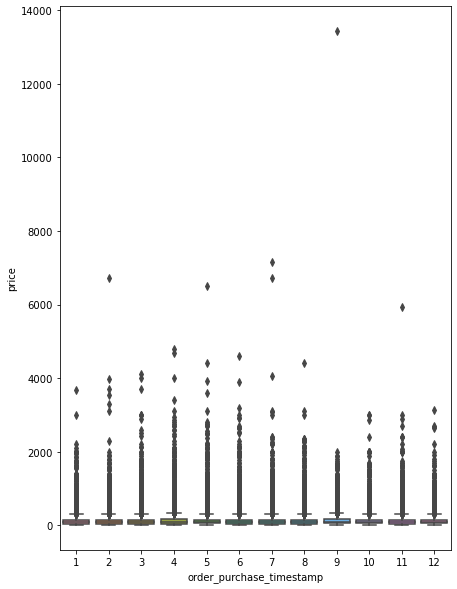

In [117]:
sns.boxplot(x = df.order_purchase_timestamp.dt.month, y = "price", data = df)
plt.gcf().set_size_inches(7, 10)
plt.show()

## 4. EDA를 통한 비즈니스 현황 분석

### 1. 매출 분석

In [6]:
### 연/월/일/요일/분기 단위로 새 컬럼 만들기
df['price'] = df.order_qty * df.avg_unit_price
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['year'] = df['order_purchase_timestamp'].dt.year
df['month'] = df['order_purchase_timestamp'].dt.month
df['day'] = df['order_purchase_timestamp'].dt.day
df['day of week'] = df['order_purchase_timestamp'].dt.day_name()
df['quarter'] = df['order_purchase_timestamp'].dt.quarter

df

,order_id,customer_id,customer_unique_id,customer_state,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,order_qty,avg_unit_price,product_id,product_category_name,seller_id,seller_state,price,year,month,day,day of week,quarter
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,RJ,delivered,2017-09-13,2017-09-20,2017-09-29,1,59,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,48436dade18ac8b2bce089ec2a041202,SP,59,2017,9,13,Wednesday,3
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,SP,delivered,2017-04-26,2017-05-12,2017-05-15,1,240,e5f2d52b802189ee658865ca93d83a8f,pet_shop,dd7ddc04e1b6c2c614352b383efe2d36,SP,240,2017,4,26,Wednesday,2
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,MG,delivered,2018-01-14,2018-01-22,2018-02-05,1,199,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,5b51032eddd242adc84c38acab88f23d,MG,199,2018,1,14,Sunday,1
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,SP,delivered,2018-08-08,2018-08-14,2018-08-20,1,13,7634da152a4610f1595efa32f14722fc,perfumery,9d7a1d34a5052409006425275ba1c2b4,SP,13,2018,8,8,Wednesday,3
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,SP,delivered,2017-02-04,2017-03-01,2017-03-17,1,200,ac6c3623068f30de03045865e4e10089,garden_tools,df560393f3a51e74553ab94004ba5c87,PR,200,2017,2,4,Saturday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97900,fffc94f6ce00a00581880bf54a75a037,b51593916b4b8e0d6f66f2ae24f2673d,0c9aeda10a71f369396d0c04dce13a64,MA,delivered,2018-04-23,2018-05-10,2018-05-18,1,300,4aa6014eceb682077f9dc4bffebc05b0,housewares,b8bc237ba3788b23da09c0f1f3a3288c,SC,300,2018,4,23,Monday,2
97901,fffcd46ef2263f404302a634eb57f7eb,84c5d4fbaf120aae381fad077416eaa0,0da9fe112eae0c74d3ba1fe16de0988b,PR,delivered,2018-07-14,2018-07-23,2018-08-01,1,350,32e07fd915822b0765e448c4dd74c828,computers_accessories,f3c38ab652836d21de61fb8314b69182,SP,350,2018,7,14,Saturday,3
97902,fffce4705a9662cd70adb13d4a31832d,29309aa813182aaddc9b259e31b870e6,cd79b407828f02fdbba457111c38e4c4,SP,delivered,2017-10-23,2017-10-28,2017-11-10,1,100,72a30483855e2eafc67aee5dc2560482,sports_leisure,c3cfdc648177fdbbbb35635a37472c53,PR,100,2017,10,23,Monday,4
97903,fffe18544ffabc95dfada21779c9644f,b5e6afd5a41800fdf401e0272ca74655,eb803377c9315b564bdedad672039306,SP,delivered,2017-08-14,2017-08-16,2017-08-25,1,56,9c422a519119dcad7575db5af1ba540e,computers_accessories,2b3e4a2a3ea8e01938cabda2a3e5cc79,SP,56,2017,8,14,Monday,3


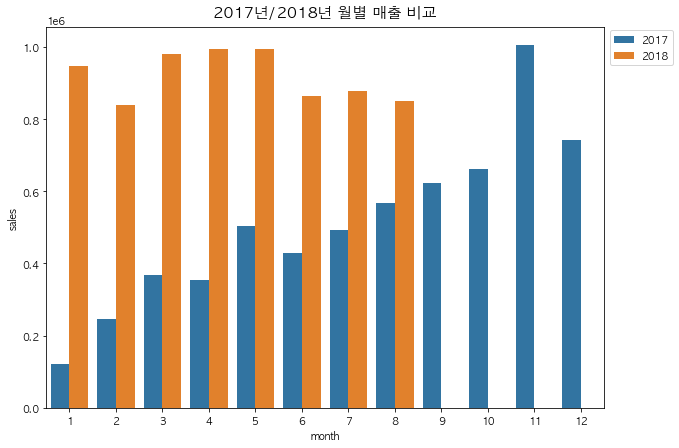

In [18]:
df_sales = df.groupby(['year','month'])['price'].sum().to_frame().reset_index()

### 연도별 월별 매출 비교
sns.barplot(data=df_sales,
            x="month",
            y="price",
            hue="year")
plt.legend(loc=(1.01, 0.9))
plt.ylabel('sales')
plt.title('2017년/2018년 월별 매출 비교', size=15, pad=10)
plt.gcf().set_size_inches(10, 7)
plt.show()

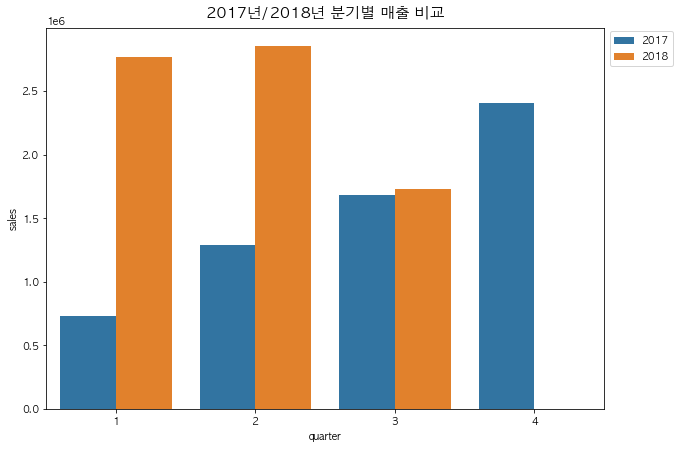

In [23]:
df_sales = df.groupby(['year','quarter'])['price'].sum().to_frame().reset_index()

### 연도별 분기별 매출 비교 >>> 3분기에 오류가 있다. 2017년의 3분기 값은 7,8,9월의 값, 2018년은 7,8월의 값이기 때문에 차이가 있다.
sns.barplot(data=df_sales,
            x="quarter",
            y="price",
            hue="year")
plt.ylabel('sales')
plt.legend(loc=(1.01, 0.9))
plt.title('2017년/2018년 분기별 매출 비교', size=15, pad=10)
plt.gcf().set_size_inches(10, 7)
plt.show()

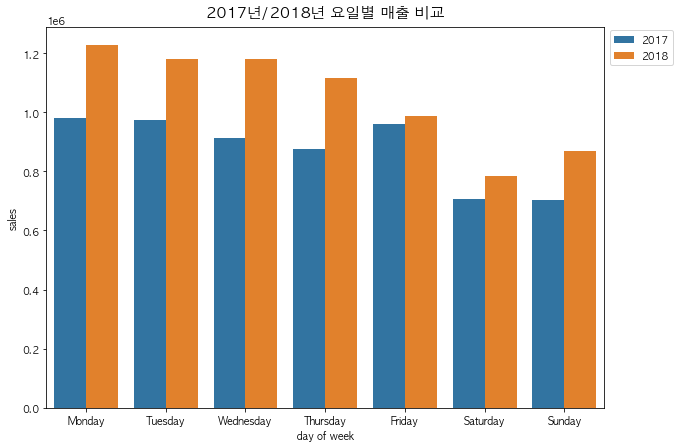

In [22]:
df_sales = df.groupby(['year','day of week'])['price'].sum().to_frame().reset_index()

### 연도별 요일별 매출 비교
sns.barplot(data=df_sales,
            x="day of week",
            y="price",
            hue="year",
            order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.ylabel('sales')
plt.legend(loc=(1.01, 0.9))
plt.title('2017년/2018년 요일별 매출 비교', size=15, pad=10)
plt.gcf().set_size_inches(10, 7)
plt.show()

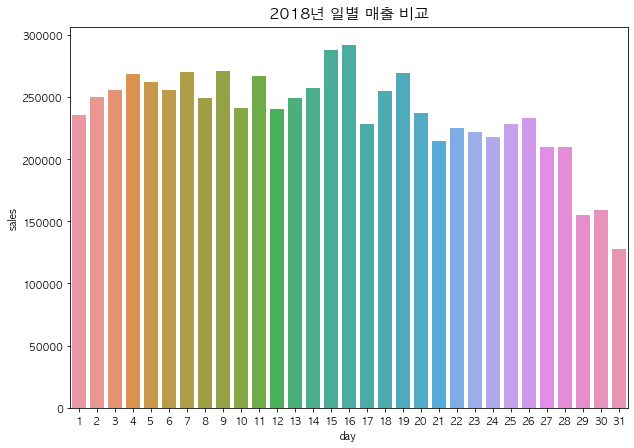

In [25]:
df_sales = df[df.year == 2018].groupby('day')['price'].sum().to_frame().reset_index()

### 2018년 일자별 매출 비교
sns.barplot(data=df_sales,
            x="day",
            y="price")
plt.ylabel('sales')
plt.title('2018년 일별 매출 비교', size=15, pad=10)
plt.gcf().set_size_inches(10, 7)
plt.show()

In [35]:
df_sales_2018['order_purchase_timestamp'].dt.date

0      2018-01-01
1      2018-01-02
2      2018-01-03
3      2018-01-04
4      2018-01-05
          ...    
236    2018-08-25
237    2018-08-26
238    2018-08-27
239    2018-08-28
240    2018-08-29
Name: order_purchase_timestamp, Length: 241, dtype: object

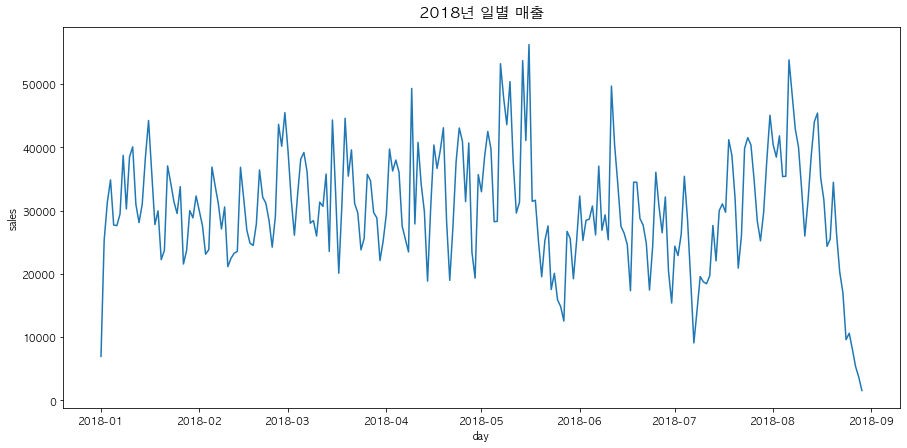

In [38]:
### 2018년 일별 매출
sns.lineplot(x = "order_purchase_timestamp", y = "price", data = df_sales_2018)
plt.gcf().set_size_inches(15, 7)
plt.ylabel('sales')
plt.xlabel('day')
plt.title('2018년 일별 매출', size=15, pad=10)
plt.show()

### 2. 구매 가격대 집계

In [12]:
### 가격대의 3분위수인 150헤알 이하의 주문 건들의 가격대 분포
df[df.year==2018].price.describe()

count    53530.000000
mean       137.169027
std        202.894971
min          1.000000
25%         46.000000
50%         88.000000
75%        150.000000
max       7160.000000
Name: price, dtype: float64

In [39]:
df_hist

,bucket,lower_limit,upper_limit,num_purchase,total_amount
0,1,1,18,2092,27686
1,2,18,34,6979,181847
2,3,34,51,7055,307161
3,4,51,67,4828,283458
4,5,67,84,4894,365798
5,6,84,100,5012,469185
6,7,100,117,2715,295931
7,8,117,133,3637,449891
8,9,133,150,2481,350976
9,10,150,167,13837,4610725


<BarContainer object of 10 artists>

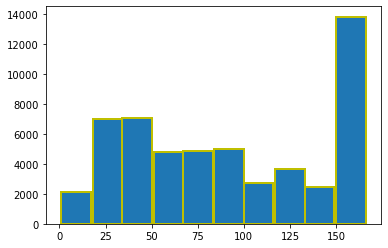

In [66]:
plt.bar(df_hist['lower_limit'],df_hist['num_purchase'], width=16, align='edge'
       , edgecolor='y', linewidth=2)

### 3. 주문 고객수 분석

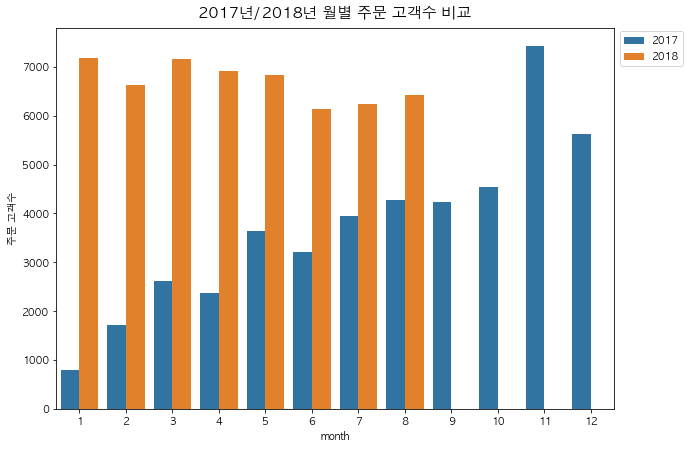

In [40]:
df_comp = df.groupby(['year','month'])['customer_id'].count().to_frame().reset_index()

### 연도별 월별 주문 건수 비교
sns.barplot(data=df_comp,
            x="month",
            y="customer_id",
            hue="year")
plt.ylabel('주문 고객수')
plt.legend(loc=(1.01, 0.9))
plt.title('2017년/2018년 월별 주문 고객수 비교', size=15, pad=10)
plt.gcf().set_size_inches(10, 7)
plt.show()

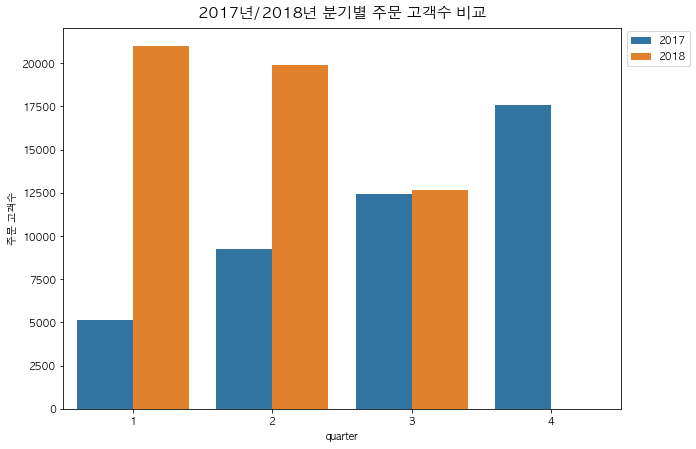

In [41]:
df_comp = df.groupby(['year','quarter'])['customer_id'].count().to_frame().reset_index()

### 연도별 분기별 주문 건수 비교
sns.barplot(data=df_comp,
            x="quarter",
            y="customer_id",
            hue="year")
plt.ylabel('주문 고객수')
plt.legend(loc=(1.01, 0.9))
plt.title('2017년/2018년 분기별 주문 고객수 비교', size=15, pad=10)
plt.gcf().set_size_inches(10, 7)
plt.show()

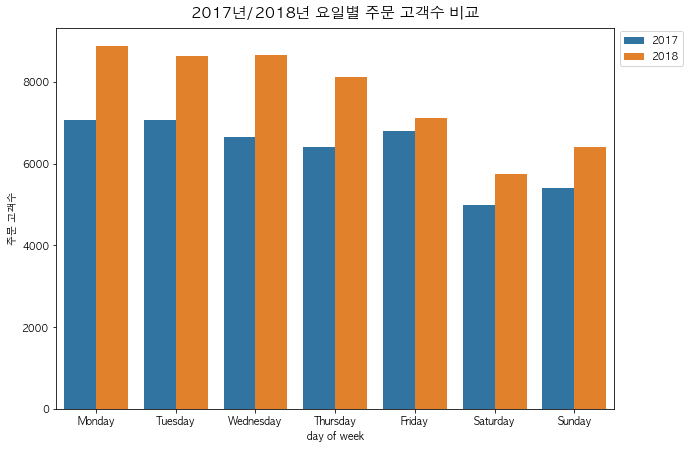

In [42]:
df_comp = df.groupby(['year','day of week'])['customer_id'].count().to_frame().reset_index()

### 연도별 요일별 주문 건수 비교
sns.barplot(data=df_comp,
            x="day of week",
            y="customer_id",
            hue="year",
            order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.ylabel('주문 고객수')
plt.legend(loc=(1.01, 0.9))
plt.title('2017년/2018년 요일별 주문 고객수 비교', size=15, pad=10)
plt.gcf().set_size_inches(10, 7)
plt.show()

### 4. 객단가(ARPPU)
= 총매출 / 결제 유저(PU)

In [43]:
df_arppu = pd.DataFrame(df.groupby(['year', 'month'])['price'].sum() / df.groupby(['year', 'month'])['customer_id'].count(), columns=['arppu']).reset_index()
df_arppu

,year,month,arppu
0,2017,1,152.662008
1,2017,2,142.633877
2,2017,3,140.790982
3,2017,4,148.906605
4,2017,5,138.273901
5,2017,6,134.190952
6,2017,7,124.800304
7,2017,8,133.065075
8,2017,9,147.049444
9,2017,10,145.226083


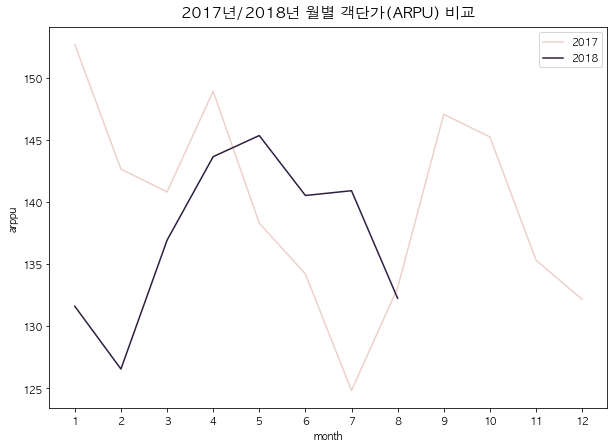

In [46]:
### 연도별 월별 객단가 비교
sns.lineplot(data=df_arppu,
            x="month",
            y="arppu",
            hue="year")
plt.legend(loc='upper right')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.gcf().set_size_inches(10, 7)
plt.title('2017년/2018년 월별 객단가(ARPU) 비교', size=15, pad=10)
plt.show()

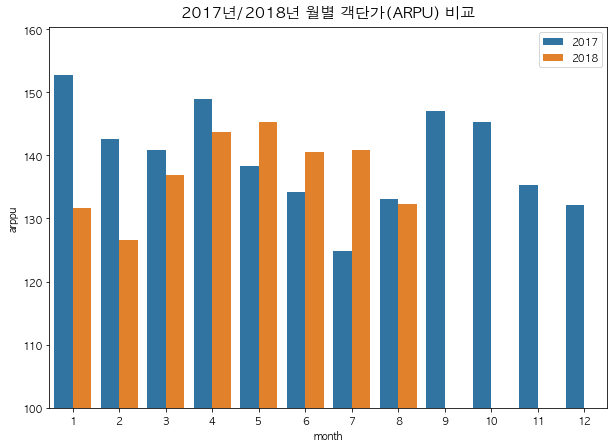

In [47]:
### 연도별 월별 객단가 비교
sns.barplot(data=df_arppu,
            x="month",
            y="arppu",
            hue="year")
plt.legend(loc='upper right')
plt.ylim(100)
plt.gcf().set_size_inches(10, 7)
plt.title('2017년/2018년 월별 객단가(ARPU) 비교', size=15, pad=10)
plt.show()

----

2023.02.15 추가 수정 진행중

----